In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf
import queue
import boto3
import random
import json
import pandas as pd
import io
import sklearn
import scipy.io.wavfile as sciwav
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.models import Segmenter1d
from src.data import load_audio, create_audio_transform, Freesound, NSynth, TUTAcousticScenes, AcousticSceneMusicSegmentation

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [7]:
class AcousticSceneMusicSegmentation(Dataset):
    def __init__(self, tut_dir, nsynth_dir, split, freesound_dir=None, sample_rate=16000, n_samples=160000, random_crop=False, feature_type='mel',
                 resize=None, normalize=False, standardize=False, standardize_mean=None, standardize_std=None, spec_augment=False):
        self.tut_dir = tut_dir
        self.freesound_dir = freesound_dir
        self.nsynth_dir = nsynth_dir
        self.split = split
        self.sample_rate = sample_rate
        self.n_samples = n_samples
        self.random_crop = random_crop
        self.feature_type = feature_type
        self.resize = resize
        self.normalize = normalize
        self.standardize = standardize
        self.standardize_mean = standardize_mean
        self.standardize_std = standardize_std
        self.spec_augment = spec_augment
        
        tut_dataset = TUTAcousticScenes(self.tut_dir, self.split)
        nsynth_dataset = NSynth(nsynth_dir, self.split)
        
        self.scene_files = tut_dataset.meta['filename'].tolist()
        self.music_files = nsynth_dataset.files
        
        if self.freesound_dir:
            freesound_dataset = Freesound(self.freesound_dir, self.split, binary=True)
            music_meta = freesound_dataset.meta[freesound_dataset.meta['label'] == 'instrument'].reset_index(drop=True)
            self.music_files += music_meta['fname'].tolist()
        
        self.transform = create_audio_transform(
            self.sample_rate,
            self.n_samples,
            random_crop=self.random_crop,
            feature_type=self.feature_type,
            resize=self.resize,
            normalize=self.normalize,
            standardize=self.standardize,
            standardize_mean=self.standardize_mean,
            standardize_std=self.standardize_std,
            spec_augment=self.spec_augment
        )
        
    def __len__(self):
        return len(self.scene_files)

    def __getitem__(self, idx):
        scene_fname = self.scene_files[idx]
        music_fname = random.choice(self.music_files)
        
        audio, start, end = self.combine_audio(scene_fname, music_fname)
        features = self.transform(audio)
        
        # create segmentation mask
        scale = (features.shape[-1] / audio.shape[-1])
        start = int(scale*start)
        end = int(scale*end)
        mask = torch.zeros(features.shape[-1], device=features.device, dtype=torch.float32)
        mask[start:end] = 1.0
        
        return features, mask, audio
    
    def combine_audio(self, scene_fname, music_fname, random_volume_reduction=False):
        scene = load_audio(scene_fname, sample_rate=self.sample_rate)
        music = load_audio(music_fname, sample_rate=self.sample_rate)
        
        # convert to mono
        scene = scene.mean(0, keepdim=True)
        music = music.mean(0, keepdim=True)
        
        # trim leading/trailing zeros from music audio
        music = torch.from_numpy(np.trim_zeros(music.squeeze().numpy())).unsqueeze(0)
        
        # truncate music audio if longer than scene audio
        if music.shape[-1] > (scene.shape[-1] - self.sample_rate*2):
            music = music[..., :scene.shape[-1] - self.sample_rate*2]
            
        # normalize music volume range to match scene volume range
        music = (((music - music.min()) * (scene.max() - scene.min())) / (music.max() - music.min())) + scene.min()
        
        # change volume of music by random factor (1 - 4)
        if random_volume_reduction:
            factor = random.random()*3 + 1.0
            music /= factor
        
        # standardize mean music volume to match mean scene volume
        music = music - (music.mean() - scene.mean())
        
        # insert music into scene
        start = random.randint(0, scene.shape[-1] - music.shape[-1] - 1)
        end = start+music.shape[-1]
        scene[..., start:end] += music
        
        return scene, start, end

In [99]:
def combine_audio(scene_fname, music_fname, random_volume_reduction=False):
    scene = load_audio(scene_fname, sample_rate=16000)
    music = load_audio(music_fname, sample_rate=16000)

    # convert to mono
    scene = scene.mean(0, keepdim=True)
    music = music.mean(0, keepdim=True)

    # trim leading/trailing zeros from music audio
    music = torch.from_numpy(np.trim_zeros(music.squeeze().numpy())).unsqueeze(0)

    # truncate music audio if longer than scene audio
    if music.shape[-1] > (scene.shape[-1] - 16000*2):
        music = music[..., :scene.shape[-1] - 16000*2]

    # normalize music volume range to match scene volume range
    music = (((music - music.min()) * (scene.max() - scene.min())) / (music.max() - music.min())) + scene.min()
    
    # change volume of music by random factor (1 - 4)
    if random_volume_reduction:
        factor = random.random()*3 + 1.0
        music /= 4.0
    
    # insert music into scene
    start = random.randint(0, scene.shape[-1] - music.shape[-1] - 1)
    end = start+music.shape[-1]
    scene[..., start:end] += music

    return scene, start, end

In [67]:
dataset = AcousticSceneMusicSegmentation('data/DCASE2018/Task1', 'data/nsynth', 'train')

In [102]:
audio, _, _ = combine_audio(dataset.scene_files[0], dataset.music_files[5], random_volume_reduction=True)

In [103]:
IPython.display.Audio(audio, rate=16000)

In [85]:
random.random()*2 + 1.0

1.1145194650680506

In [19]:
IPython.display.Audio(audio, rate=16000)

test


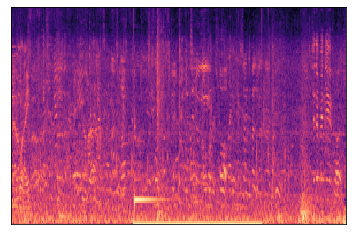

In [28]:
print('test')
librosa.display.specshow(features.numpy().squeeze(), sr=16000)

In [ ]:
librosa.display.specshow((mask*features).numpy().squeeze(), sr=16000)

In [118]:
audio_mask = F.interpolate(mask.float()[None, None, ...], size=audio.shape[-1]).squeeze().numpy()

In [119]:
music = np.trim_zeros((audio*audio_mask).numpy().squeeze())

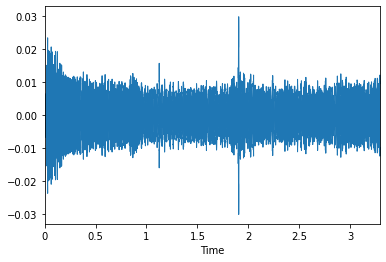

In [120]:
librosa.display.waveplot(music, sr=16000)

In [121]:
IPython.display.Audio(music, rate=16000)

In [170]:
features.mean(0, keepdim=True).shape

torch.Size([1, 128, 626])

In [12]:
model = Segmenter1d(h_dim=512, sigmoid=True)

In [13]:
inputs = features.unsqueeze(0)

In [14]:
model.eval()
outputs = model(inputs)

In [15]:
outputs.mean()

tensor(0.4956, grad_fn=<MeanBackward0>)

In [16]:
mask.unsqueeze(0).shape

torch.Size([1, 626])

In [17]:
outputs.shape

torch.Size([1, 626])

In [18]:
loss_fn = nn.BCELoss()

In [19]:
loss_fn(outputs, mask.unsqueeze(0))

tensor(0.6911, grad_fn=<BinaryCrossEntropyBackward>)

In [20]:
type(mask)

torch.Tensor

In [21]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [22]:
for batch in train_dataloader:
    break

In [23]:
batch[0].shape, batch[1].shape

(torch.Size([32, 1, 128, 626]), torch.Size([32, 626]))

In [24]:
batch[1]

tensor([[0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [31]:
data_dir = 'data/DCASE2018/Task1'

train_dir = os.path.join(data_dir, 'TUT-urban-acoustic-scenes-2018-development')

train_meta = pd.read_csv(os.path.join(train_dir, 'meta.csv'), delimiter='\t')

In [32]:
train_meta.head()

,filename,scene_label,identifier,source_label
0,audio/airport-barcelona-0-0-a.wav,airport,barcelona-0,a
1,audio/airport-barcelona-0-1-a.wav,airport,barcelona-0,a
2,audio/airport-barcelona-0-2-a.wav,airport,barcelona-0,a
3,audio/airport-barcelona-0-3-a.wav,airport,barcelona-0,a
4,audio/airport-barcelona-0-4-a.wav,airport,barcelona-0,a


In [4]:
lengths = []
errors = 0
for i, f in enumerate(train_meta['filename']):
    f = os.path.join(train_dir, f)
    try:
        audio = load_audio(f, sample_rate=16000)
    except:
        errors += 1
        continue
        
    lengths.append(audio.shape[-1] / 16000)
    if (i+1 % 1000) == 0:
        print(i+1)

In [6]:
sum(lengths) / len(lengths)

10.0

In [7]:
max(lengths)

10.0

In [8]:
min(lengths)

10.0

In [9]:
errors

1

NameError: name 'train_meta' is not defined

In [96]:
freesound_dir = 'data/freesound'

train_dir = os.path.join(freesound_dir, 'FSDKaggle2018.audio_train')
test_dir = os.path.join(freesound_dir, 'FSDKaggle2018.audio_test')

train_meta_path = os.path.join(freesound_dir, 'FSDKaggle2018.meta/train_post_competition.csv')
test_meta_path = os.path.join(freesound_dir, 'FSDKaggle2018.meta/test_post_competition_scoring_clips.csv')

In [97]:
train_meta = pd.read_csv(train_meta_path)
test_meta = pd.read_csv(test_meta_path)

In [37]:
instruments = [
    'Acoustic_guitar',
    'Violin_or_fiddle',
    'Trumpet',
    'Cello',
    'Double_bass',
    'Saxophone',
    'Clarinet',
    'Bass_drum',
    'Flute',
    'Hi-hat',
    'Snare_drum',
    'Oboe',
    'Gong',
    'Tambourine',
    'Cowbell',
    'Harmonica',
    'Electric_piano',
    'Chime',
    'Glockenspiel'
]

non_instruments = [x for x in train_meta['label'].unique() if x not in instruments]

NameError: name 'train_meta' is not defined

In [99]:
train_meta.head(10)

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution
5,003b91e8.wav,Cello,0,77944,Attribution
6,003da8e5.wav,Knock,1,164564,Creative Commons 0
7,0048fd00.wav,Gunshot_or_gunfire,1,274119,Creative Commons 0
8,004ad66f.wav,Clarinet,0,248370,Attribution
9,0063ab88.wav,Computer_keyboard,0,210304,Creative Commons 0


In [76]:
fname = os.path.join(train_dir, train_meta.loc[17]['fname'])

audio = load_audio(fname, sample_rate=16000, t_start=0)

In [77]:
librosa.load(fname, sr=16000)[0].shape

(248320,)

In [78]:
audio.shape

torch.Size([1, 248320])

In [79]:
IPython.display.Audio(audio, rate=16000)

In [109]:
times = []
for i, fname in enumerate(train_meta['fname']):
    fname = os.path.join(train_dir, fname)
    audio = load_audio(fname, sample_rate=16000)
    times.append(audio.shape[-1] / 16000)
    
    if ((i+1) % 1000) == 0:
        print(i+1)
        print(sum(times) / len(times))

1000
6.687480000000004
2000
6.739890000000001
3000
6.765840000000015
4000
6.7557399999999985
5000
6.757627999999999
6000
6.723183333333323
7000
6.77814857142855


KeyboardInterrupt: 

In [47]:
import torchaudio

In [23]:
fname = 'data/nsynth/nsynth-test/audio/organ_electronic_057-047-100.wav'

audio = load_audio(fname, sample_rate=16000, t_start=0)

In [24]:
transform = create_audio_transform(
    16000,
    64000,
    random_crop=False,
    feature_type='mel',
    resize=None,
    normalize=False,
    standardize=False,
    standardize_mean=None,
    standardize_std=None,
    spec_augment=False,
)

In [25]:
x = transform(audio)

In [26]:
x.shape

torch.Size([1, 128, 251])

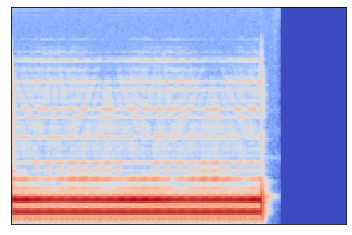

In [27]:
librosa.display.specshow(x.numpy().squeeze(), sr=16000)

In [35]:
y = librosa.db_to_amplitude(x.numpy().squeeze())
y = librosa.feature.inverse.mel_to_audio(y, sr=16000, n_fft=1024, hop_length=256)

In [36]:
IPython.display.Audio(audio, rate=16000)

In [37]:
IPython.display.Audio(y, rate=16000)

In [90]:
a = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256)(audio)

In [76]:
a = torchaudio.transforms.InverseMelScale(n_stft=1024, sample_rate=16000)(a)

In [86]:
a = torchaudio.functional.istft(a, n_fft=1024, hop_length=256)

AssertionError: one_sided implies that n_fft // 2 + 1 == fft_size and not one_sided implies n_fft == fft_size. Given values were onesided: True, n_fft: 1024, fft_size: 1

In [79]:
a.shape

torch.Size([1, 513, 251])

In [94]:
IPython.display.Audio(audio, rate=16000)

In [ ]:
a = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256)(audio)

In [91]:
b = librosa.feature.inverse.mel_to_audio(a.numpy().squeeze(), sr=16000, n_fft=1024, hop_length=256, norm=None, htk=True)

In [93]:
IPython.display.Audio(b, rate=16000)

In [ ]:
x

In [462]:
train_dataset = NSynthDataset(
    'data/nsynth/nsynth-train', 
    include_meta=True, 
    instrument_source=(0, 1, 2), 
    sample_rate=16000, 
    n_samples=64000, 
    feature_type='mel', 
    random_crop=True, 
    resize=None, 
    normalize=True, 
    standardize=False, 
    standardize_mean=None, 
    standardize_std=None, 
    freq_mask=True, 
    time_mask=True, 
    remove_synth_lead=False, 
    n_samples_per_class=None
)

In [465]:
means, stds = [], []
for x in train_dataset:
    means.append(x[0].mean())
    stds.append(x[0].std())
    
means = torch.stack(means).mean()
stds = torch.stack(stds).mean()

In [469]:
print(means, stds)

tensor(0.3356) tensor(0.2212)


In [446]:
fname = 'data/nsynth/nsynth-test/audio/organ_electronic_057-047-100.wav'

audio = load_audio(fname, sample_rate=16000, t_start=0)

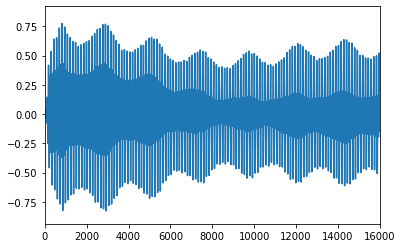

In [447]:
plt.xlim(0, 16000)
plt.plot(audio.numpy()[0])

In [429]:
transform = create_audio_transform(
    16000,
    64000,
    random_crop=True,
    feature_type='mel',
    resize=None,
    normalize=True,
    standardize=True,
    standardize_mean=None,
    standardize_std=None,
    freq_mask=True,
    time_mask=True,
    time_dim=-1,
    freq_dim=-2,
)

In [436]:
features = transform(audio)

In [437]:
features.shape

torch.Size([1, 128, 251])

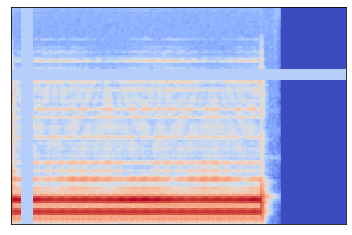

In [438]:
librosa.display.specshow(features.numpy().squeeze(), sr=16000)

In [2]:
def extract_features(bucket, wav_key, feat='mfcc'):
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, wav_key)
    sample_rate, X = sciwav.read(io.BytesIO(obj.get()['Body'].read()))
    X = X.astype(np.float32)

    
    if feat == 'mfcc':
        features = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    elif feat == 'mel':
        features = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=1024, hop_length=256)
    else:
        raise Exception('feat must be "mfcc" or "mel"')
    
    return features

In [5]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='music-ml-gigioli', Key='data/nsynth/nsynth-train/examples.json')

train_examples = json.loads(obj['Body'].read().decode('utf-8'))

In [6]:
k = list(train_examples.keys())[0]

In [7]:
s3 = boto3.resource('s3')
obj = s3.Object('music-ml-gigioli', 'data/nsynth/nsynth-train/audio/{}.wav'.format(k))
sample_rate, X = sciwav.read(io.BytesIO(obj.get()['Body'].read()))
X = X.astype(np.float32)

In [8]:
mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
mels = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=1024, hop_length=256)

In [9]:
mels.shape

(128, 251)

In [10]:
mfccs.shape

(40, 126)

In [21]:
IPython.display.Audio(X, rate=16000)

In [22]:
signal = librosa.feature.inverse.mfcc_to_audio(mfccs, n_mels=128)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [23]:
IPython.display.Audio(signal, rate=16000)

In [15]:
test = {}
for k, v in train_examples.items():
    if v['instrument_source'] in (0, ):
        test[k] = v

In [16]:
len(test)

102165

In [9]:
test = dict([(k, v) for k, v in train_e])

In [10]:
len(test)

289205

In [7]:
list(train_examples.keys())[0]

'guitar_acoustic_001-082-050'

In [6]:
train_examples[list(train_examples.keys())[0]]

{'note': 16629,
 'sample_rate': 16000,
 'pitch': 82,
 'instrument_source': 0,
 'instrument_family_str': 'guitar',
 'instrument_str': 'guitar_acoustic_001',
 'note_str': 'guitar_acoustic_001-082-050',
 'qualities_str': ['percussive'],
 'instrument_source_str': 'acoustic',
 'velocity': 50,
 'instrument_family': 3,
 'instrument': 39,
 'qualities': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]}

In [161]:
# number of acoustic samples
len([k for k, v in train_examples.items() if v['instrument_source'] == 0])

102165

In [167]:
%%timeit
# how long it takes to extract one acoustic sample
_ = extract_features('music-ml-gigioli', 'data/nsynth/nsynth-train/audio/{}.wav'.format(k))

68.8 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
# duration in hours
0.0688 * 102165 / 60 / 60

1.9524866666666667

In [166]:
mfccs = []
for i, x in enumerate(train_examples.items()):
    k, v = x
    mfccs.append(extract_features('music-ml-gigioli', 'data/nsynth/nsynth-train/audio/{}.wav'.format(k)))
    
    if i+1 % 1000 == 0:
        print(i+1)

KeyboardInterrupt: 

In [160]:
train_examples[list(train_examples.keys())[18]]

{'note': 281566,
 'sample_rate': 16000,
 'pitch': 92,
 'instrument_source': 2,
 'instrument_family_str': 'bass',
 'instrument_str': 'bass_synthetic_037',
 'note_str': 'bass_synthetic_037-092-050',
 'qualities_str': ['distortion'],
 'instrument_source_str': 'synthetic',
 'velocity': 50,
 'instrument_family': 0,
 'instrument': 443,
 'qualities': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]}

In [7]:
mfcc = extract_features(
    'music-ml-gigioli', 'data/nsynth/nsynth-train/audio/' + list(train_examples.keys())[12] + '.wav', 'mfcc'
)

In [162]:
(mfcc.nbytes * 102165) / (1e9)

2.0596464

In [26]:
mfcc.shape

(40, 126)

In [8]:
mfcc_norm = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min())

In [10]:
mfcc_norm

array([[1.        , 0.9569698 , 0.82021964, ..., 0.54006416, 0.54006416,
        0.54006416],
       [0.17692208, 0.17427774, 0.14848924, ..., 0.07117005, 0.07117005,
        0.07117005],
       [0.        , 0.00203744, 0.01367589, ..., 0.07117005, 0.07117005,
        0.07117005],
       ...,
       [0.05358678, 0.04990854, 0.03902034, ..., 0.07117005, 0.07117005,
        0.07117005],
       [0.0686168 , 0.06878196, 0.05992614, ..., 0.07117005, 0.07117005,
        0.07117005],
       [0.05198931, 0.05282843, 0.06393671, ..., 0.07117005, 0.07117005,
        0.07117005]], dtype=float32)

In [18]:
mfcc_scaled = sklearn.preprocessing.scale(mfcc, axis=1)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


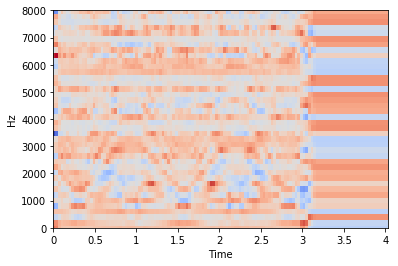

In [19]:
librosa.display.specshow(mfcc_scaled, sr=16000, x_axis='time', y_axis='hz')

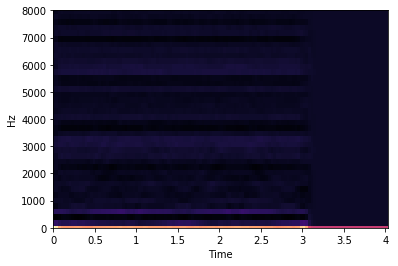

In [9]:
librosa.display.specshow(mfcc_norm, sr=16000, x_axis='time', y_axis='hz')

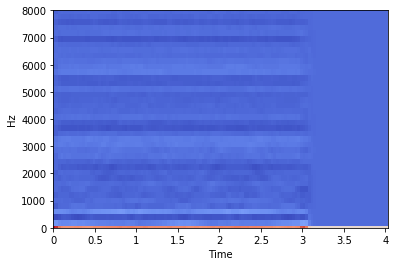

In [137]:
librosa.display.specshow(mfcc, sr=16000, x_axis='time', y_axis='hz')